# Sentiment Analysis of Amazon Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('bmh')
plt.rcParams.update({'font.size': 7, 'font.family': 'monospace'})

In [2]:
# Import data
df = pd.read_csv('../data/amazon_reviews.csv')
df = df.head(500)
df = df.reset_index()
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


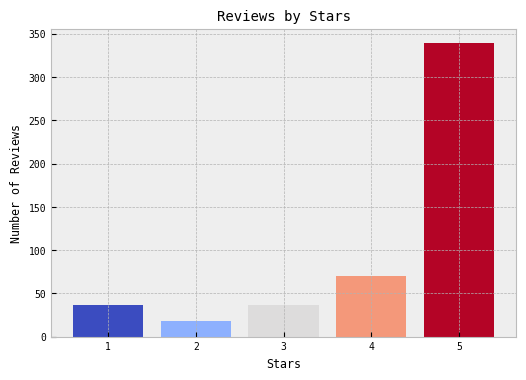

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   500 non-null    int64 
 1   Id                      500 non-null    int64 
 2   ProductId               500 non-null    object
 3   UserId                  500 non-null    object
 4   ProfileName             500 non-null    object
 5   HelpfulnessNumerator    500 non-null    int64 
 6   HelpfulnessDenominator  500 non-null    int64 
 7   Score                   500 non-null    int64 
 8   Time                    500 non-null    int64 
 9   Summary                 500 non-null    object
 10  Text                    500 non-null    object
dtypes: int64(6), object(5)
memory usage: 43.1+ KB


In [14]:
# Exploratory analysis
# add one coor for each bar
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = cmap(np.linspace(0, 1, 5))
ax = df['Score'].value_counts().sort_index().plot(
    kind='bar',
    title='Reviews by Stars',
    figsize=(6, 4), 
    color=cmap,
    #reduce the distance between the bars
    width=0.8
    )

ax.set_xlabel('Stars')
ax.set_ylabel('Number of Reviews')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

df.info()

## VADER Sentiment Scoring

Vader (Valence Aware Dictionary and sEntiment Reasoner) is a pre-trained sentiment analysis model. VADER analyzes text based on a predefined list of words and their associated sentiment scores.
- PROS: easy to use and handles informal text.
- CONS: limited contextual understanding and domain dependence.

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [5]:
# Test the sentiment analyzer object
print(sia.polarity_scores('I love this product'))
print(sia.polarity_scores('I hate this product'))
print(sia.polarity_scores('I love this product so much'))
print(sia.polarity_scores('I hate this product so much'))

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}
{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}
{'neg': 0.481, 'neu': 0.519, 'pos': 0.0, 'compound': -0.5719}


In [6]:
# Apply the sentiment analyzer to the reviews
res = {}
for i in range(len(df)):
    row = df.iloc[i]
    text = row['Text']
    res[i]= sia.polarity_scores(text)
    
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index()
vaders = vaders.merge(df, on='index')

vaders

,index,neg,neu,pos,compound,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0.000,0.695,0.305,0.9441,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,0.138,0.862,0.000,-0.5664,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,0.091,0.754,0.155,0.8265,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,0.000,1.000,0.000,0.0000,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,0.000,0.552,0.448,0.9468,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.000,0.554,0.446,0.9725,496,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,496,0.059,0.799,0.142,0.7833,497,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,497,0.025,0.762,0.212,0.9848,498,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,498,0.041,0.904,0.055,0.1280,499,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


/var/folders/jx/lwds109d5r1bxh1m4psg2s_c0000gn/T/ipykernel_34828/2957851076.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=vaders, x='Score', y='compound', palette=cmap)
/var/folders/jx/lwds109d5r1bxh1m4psg2s_c0000gn/T/ipykernel_34828/2957851076.py:1: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=vaders, x='Score', y='compound', palette=cmap)


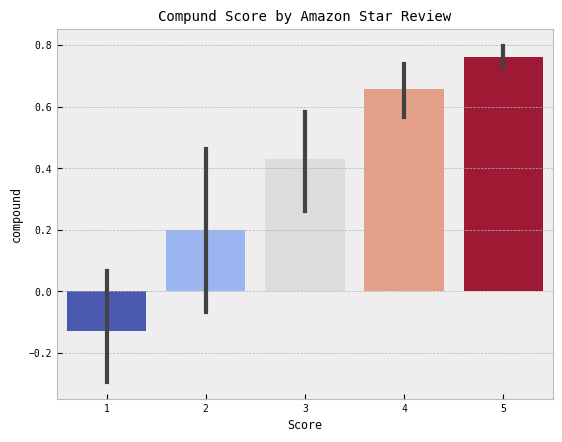

In [8]:
ax = sns.barplot(data=vaders, x='Score', y='compound', palette=cmap)
ax.set_title('Compund Score by Amazon Star Review')
plt.show()